# This file serves to demonstrate how to use a function defined in this package.
Specifically, it serves to show how to use the calc_calc_hysteresis_area_1D function to compute hysteresis area.

Note that the ref_axis needs to be strictly monotonically changing to the global extremum and strictly monotonically changing afterwards. Otherwise, unwanted behaviour can occur.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Importing the functions from the package
import sys
sys.path.insert(0,'/home/ekoehn/software/')
import hysteresis # import the package
from hysteresis import hyst_areas as ha # import the submodule hyst_areas

import importlib
importlib.reload(ha)

<module 'hysteresis.hyst_areas' from '/home/ekoehn/software/hysteresis/hyst_areas.py'>

## Set up the demo

In [82]:
# Define dimensions
n_years = 180
n_lat = 50
n_lon = 100

# Generate coordinate arrays
years = np.arange(n_years)
lats = np.linspace(-90, 90, n_lat)
lons = np.linspace(-180, 180, n_lon)

# Create a meshgrid of lat/lon to generate unique sinusoidal patterns at each location
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Generate a unique sinusoidal signal at each (lat, lon) location
# The phase and amplitude vary slightly per location for uniqueness
amplitudes = 1 + 0.5 * np.sin(np.radians(lat_grid))  # Amplitude varies with latitude
phases = np.radians(lon_grid)  # Phase shift varies with longitude

# Create the time-dependent data
data = np.array([
    amplitudes * np.sin(2 * np.pi * years[i] / n_years + phases)
    for i in range(n_years)
])

# Convert to an xarray DataArray
da = xr.DataArray(
    data,
    coords={"year": years, "lat": lats, "lon": lons},
    dims=["year", "lat", "lon"]
)

# Dfine the reference axis
ref_axis = np.sin(np.linspace(-np.pi/2,3/2*np.pi,n_years)) # strictly monotonically increasing and then strictly monotonically decreasing reference axis over a 2pi cycle


## Plot example locations

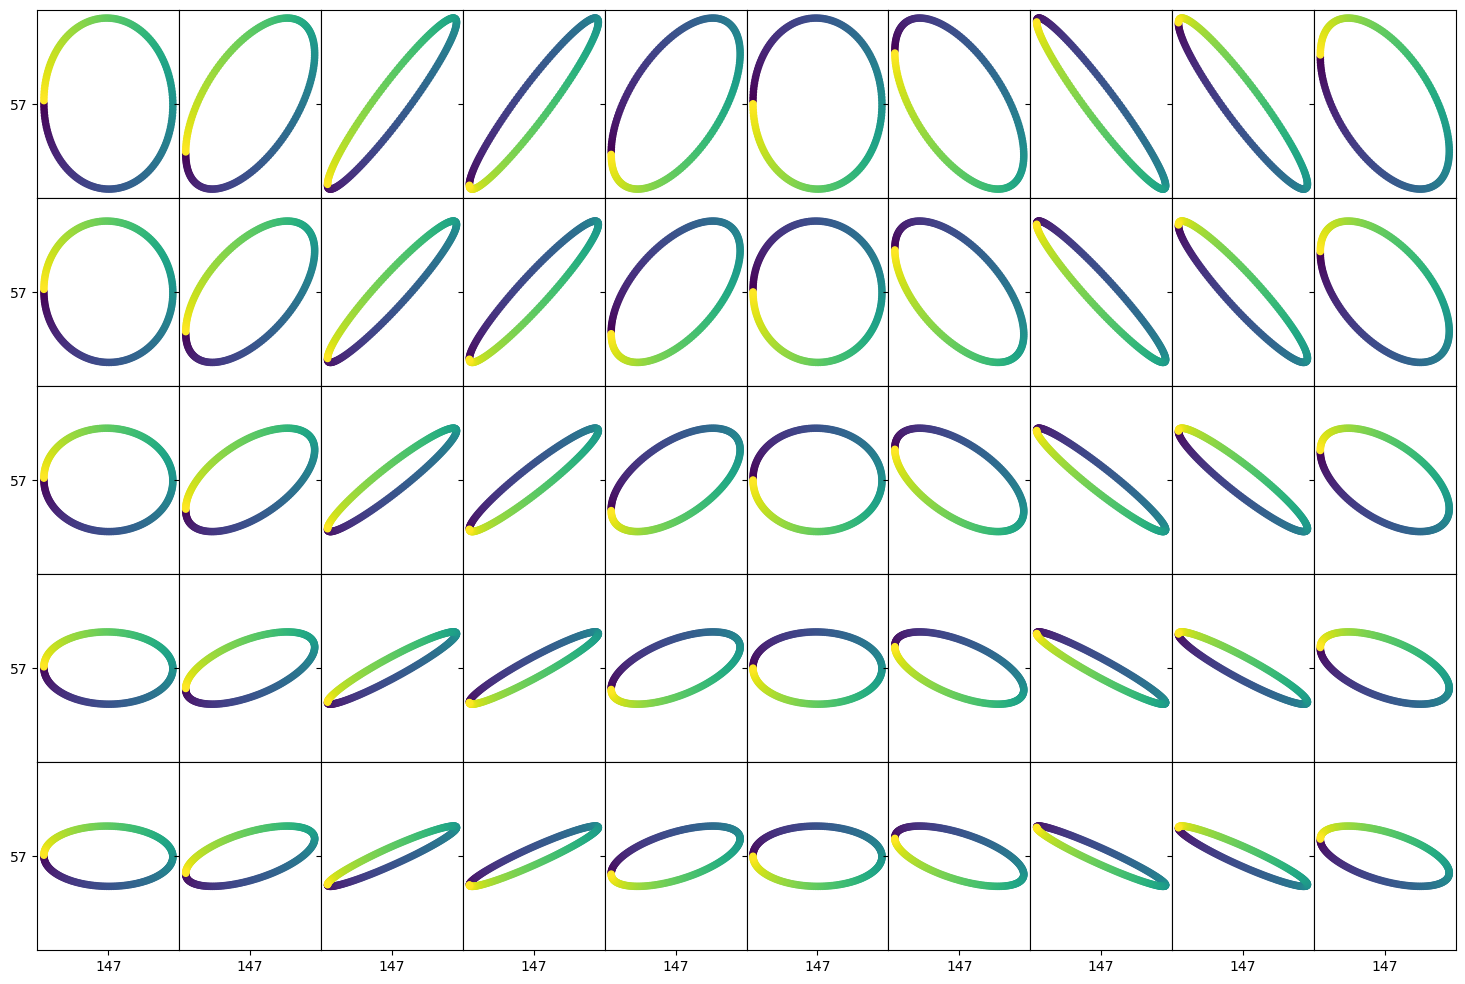

In [133]:
res = 10
fig,ax = plt.subplots(int(n_lat/res),int(n_lon/res),sharex=True,sharey=True,figsize=(15,10))
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)

for lati,lat in enumerate(lats[::res]):
    for loni,lon in enumerate(lons[::res]):
        # "flip" the lati to have the right order from "north" to "south" in the way the subplots appear
        lati2 = np.size(lats[::res])-lati-1
        ax[lati2,loni].scatter(ref_axis,da.sel(lat=lat,lon=lon),20,np.arange(n_years))
        ax[-1,loni].set_xticks([0])
        ax[-1,loni].set_xticklabels([f'{lon:.0f}'])
        ax[lati2,0].set_yticks([0])
        ax[lati2,0].set_yticklabels([f'{lat:.0f}'])
        #ax[lati2,loni].set_frame_on(False)


## Do the calculation of the hysteresis area and return the interpolated vectors etc.

In [84]:
normalizer = 'min_max_diff_full_cycle'
ds = ha.calc_hysteresis_area_3D(ref_axis, da, nsteps=1000, normalizer=normalizer)

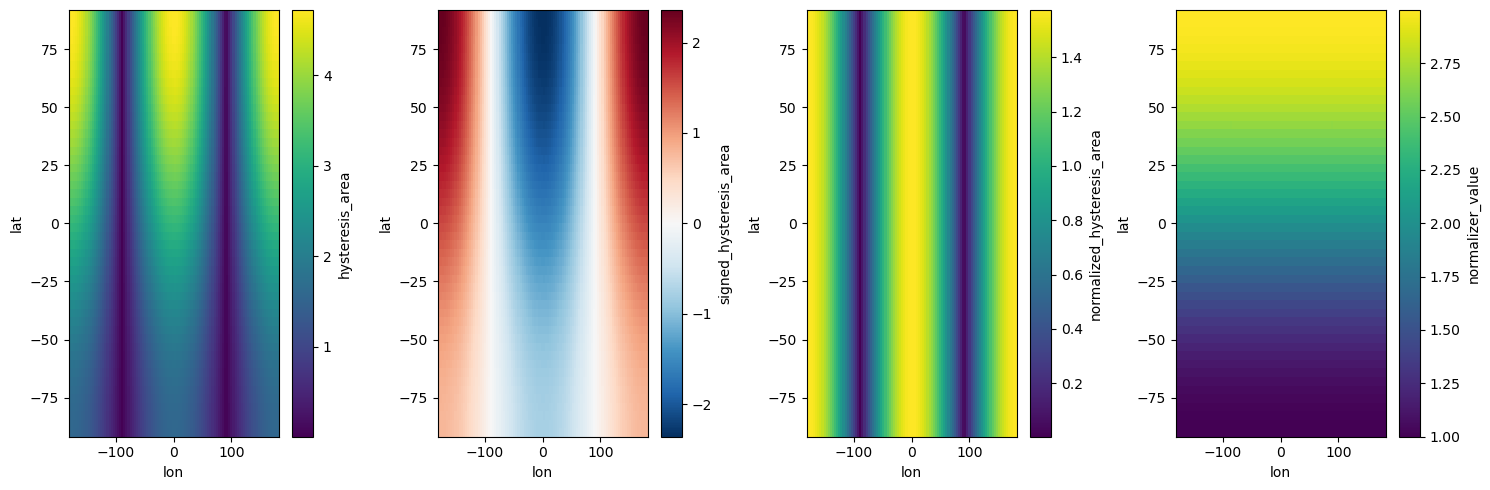

In [86]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
ds.hysteresis_area.plot(ax=ax[0])
ds.signed_hysteresis_area.plot(ax=ax[1])
ds.normalized_hysteresis_area.plot(ax=ax[2])
ds.normalizer_value.plot(ax=ax[3])
plt.tight_layout()
plt.show()